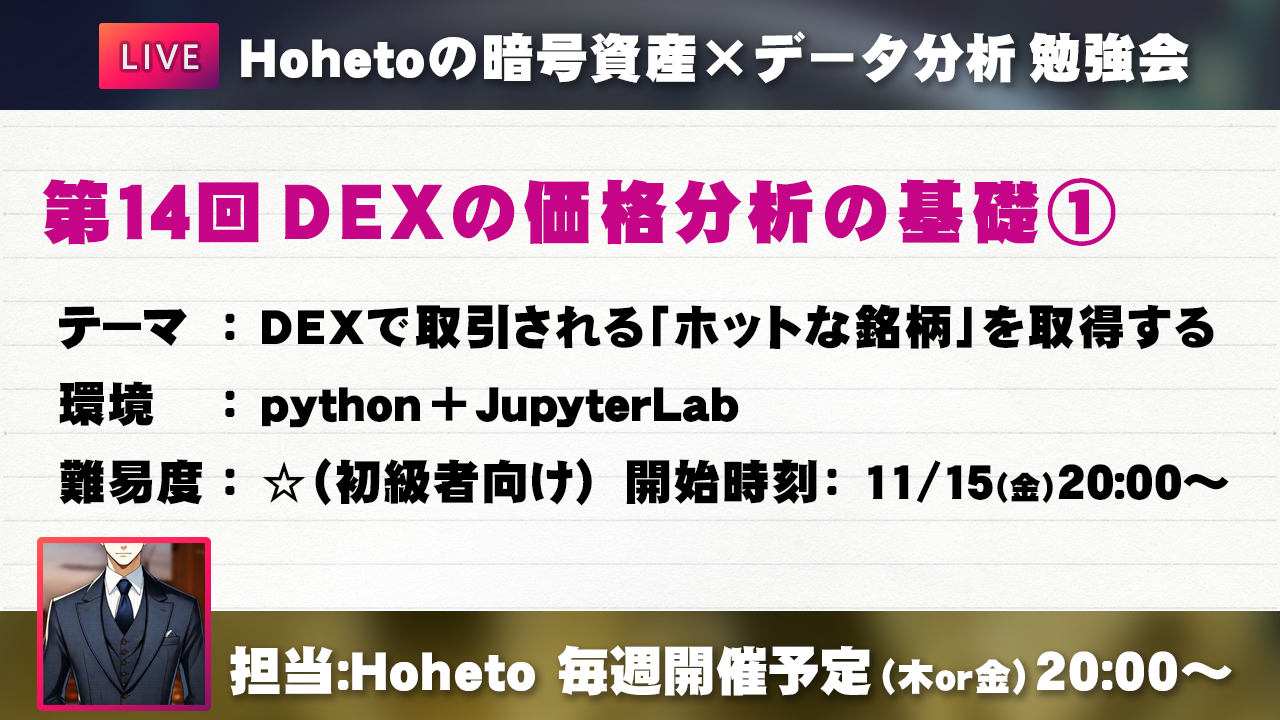

In [1]:
from IPython.display import Image

Image('./images/14_00.png')

# Hoheto勉強会 第14回 DEXの価格分析の基礎①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- DEXで取引されているトークンの出来高や価格を取得できるようにします。
- データ分析の範囲が広がります。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆1つ。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

In [5]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

# DEXとは

- 分散型取引所（Decentralized Exchange）の略。
- いわゆる中央集権取引所とは違い、
  - ユーザーが自由にトークンを上場（＝流動性を提供）できたりする。
  - アカウント作成を必要とせず、ウォレットを接続して利用する。
- 各チェーンごとに存在する。複数チェーンに対応しているものもある（L2含む）。

- メリット
  - 取引できる銘柄がCEXよりも格段に増える。
  - CEXにはない様々な戦略を構築できる。Atomic Arb、流動性提供やステーキングなどによるAPY獲得、CEXとの鞘取りなど。
- デメリット
  - 詐欺的なものが多い。
  - 上場できるトークンの99.9%以上はクズ。
  - プロジェクトがハッキングを受けたり、ラグプル（プロジェクト閉鎖や逃亡）の可能性がある。

- 何が起こっても自己責任の世界である。

# DEXの情報取得

- 本来、各チェーンごとに提供されているSDK（開発キット）を使ったり、各DEXで提供されるSDKやAPIを使って情報を取得する。
- 最近はDEXのチャート機能を提供しているサービスがあり、APIを提供しているものがある。
- 今回は勉強会ということで、このAPIを使っていく。
- ※本来、ガチでDEXで勝負するならブロックチェーンのブロック情報を自前で取得する、トランザクションを自分で発行するなどが必要。ここでは触れません。

## BirdEye

- https://v2.birdeye.so/
- 主要チェーンで取引されているトークンをチャートで表示可能。
- 大口トレーダーのポートフォリオ内容なども閲覧できる。

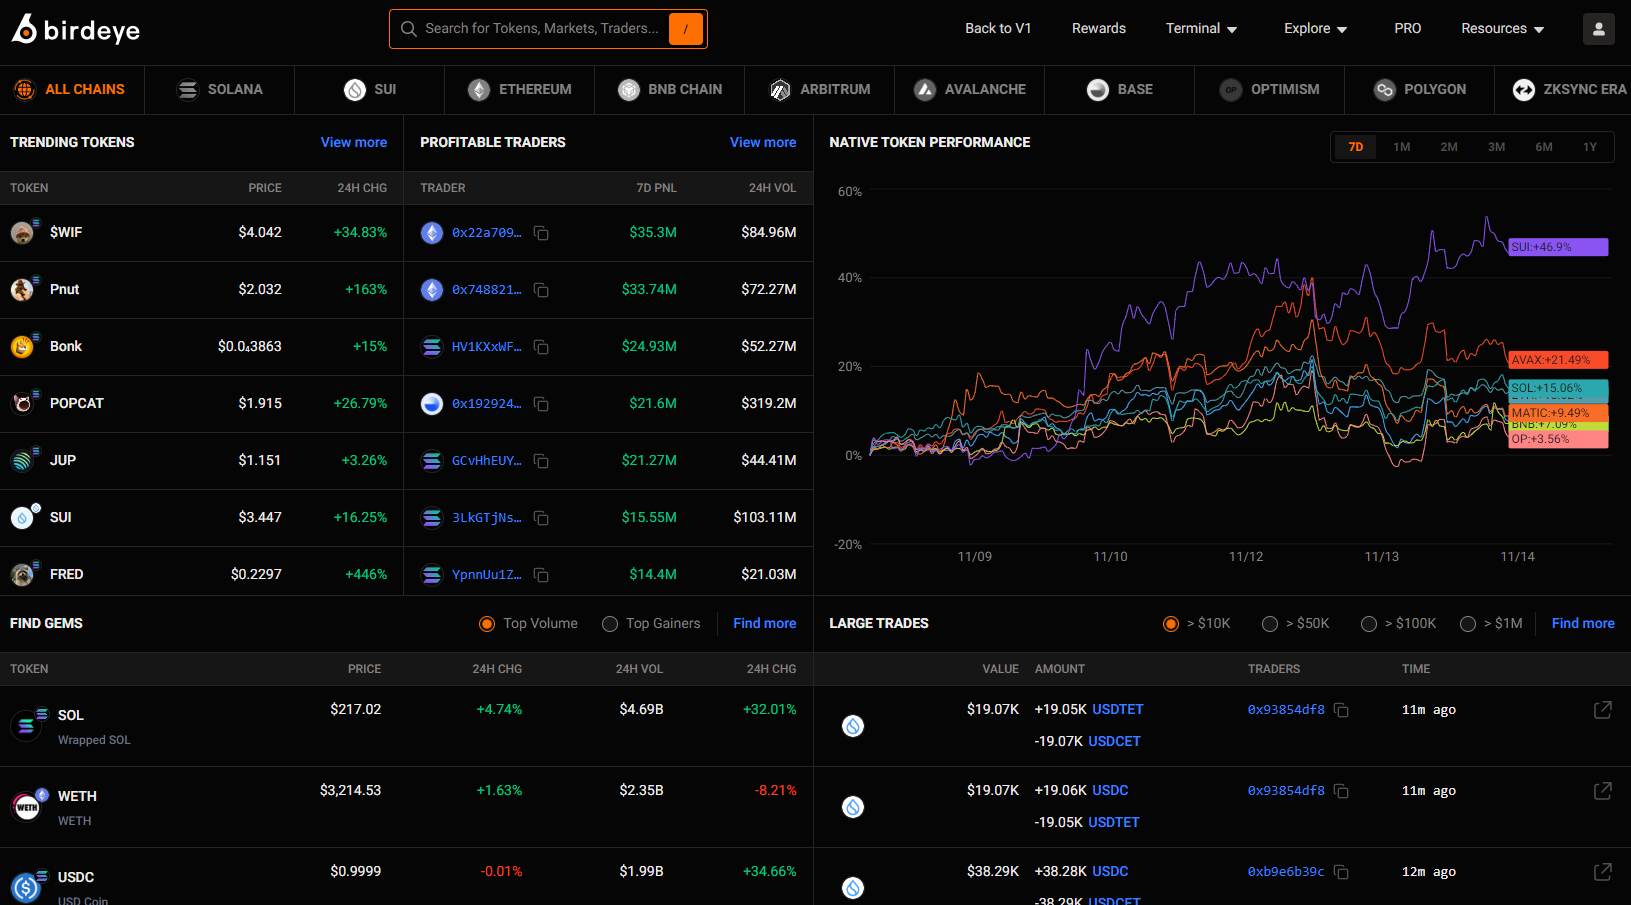

In [6]:
Image('./images/14_01.png', width=1000)

## BirdEyeのAPI

- https://bds.birdeye.so/#pricing
- https://docs.birdeye.so/docs/data-accessibility-by-packages
- https://docs.birdeye.so/docs
- 機能はかなり制限されるが、無料で利用可能。

### 使用可能なAPI

- Price
- Historical Price
- Token List

- 上記を利用して、SolanaチェーンのDEXで取引されているホットな銘柄の情報を取得していきます。

# クラスを定義

In [35]:
import requests

class BirdEye:
    def __init__(self):
        self.base_url = 'https://public-api.birdeye.so'
        self.api_key = 'YOUR-API-KEY'

    def network(self):
        # {'success': True, 'data': ['solana', 'ethereum', ...]}
        url = f'{self.base_url}/defi/networks'
        headers = {
            'X-API-KEY': self.api_key
        }
        result = requests.get(url, headers=headers).json()
        if not result['success']:
            raise Exception(result)
        return result['data']

    def price(self, chain, address):
        # {'data': {'value': 214.06165816970713, 'updateUnixTime': 1731592538, 'updateHumanTime': '2024-11-14T13:55:38'},'success': True}
        url = f'{self.base_url}/defi/price?address={address}'
        headers = {
            "accept": "application/json",
            "x-chain": chain,
            "X-API-KEY": self.api_key
        }
        result = requests.get(url, headers=headers).json()
        if not result['success']:
            raise Exception(result)
        return result['data']

    def history_price(self, chain, address, from_time, to_time, interval='15m'):
        url = f"{self.base_url}/defi/history_price?address={address}&time_from={int(from_time)}&time_to={int(to_time)}&address_type=token&type={interval}"
        headers = {
            "accept": "application/json",
            "x-chain": chain,
            "X-API-KEY": self.api_key
        }
        result = requests.get(url, headers=headers).json()
        if not result['success']:
            raise Exception(result)
        prices = pd.DataFrame(result['data']['items'])
        prices['datetime'] = pd.to_datetime(prices['unixTime'], unit='s', utc=True)
        prices = prices.set_index('datetime').sort_index()
        return prices

    def token_list(self, chain, sort='volume', asc=True, limit=50, min_liquidity=10000):
        # APIコール1回の取得件数は50件.
        # 50件以上指定すると, APIコールを繰り返すので注意.
        # {'success': True, 'data': {'updateUnixTime': 1731561455, 'updateTime': '2024-11-14T05:17:35', 
        #  'tokens': [{'address': 'So11111111111111111111111111111111111111112', 'decimals': 9, 'lastTradeUnixTime': 1731560848, 'liquidity': 17175394119.58488, 'logoURI': '', 'mc': 129325133015.5246, 'name': 'Wrapped SOL', 'symbol': 'SOL', 'v24hChangePercent': 21.686510065503096, 'v24hUSD': 4517190643.785882},
        sort_by = {
            'volume': 'v24hUSD',
            'price': 'v24hChangePercent',
            'marketcap': 'mc'
        }[sort]
        sort_type = 'asc' if asc else 'desc'
        headers = {
            "accept": "application/json",
            "x-chain": chain,
            "X-API-KEY": self.api_key
        }
        tokens = []
        for offset in range(0, limit, 50):
            url = f"{self.base_url}/defi/tokenlist?sort_by={sort_by}&sort_type={sort_type}&offset={offset}&limit=50&min_liquidity={min_liquidity}"
            result = requests.get(url, headers=headers).json()
            if not result['success']:
                raise Exception(result)
            for token in result['data']['tokens']:
                tokens.append({'symbol': token['symbol'], 'name': token['name'], 'address': token['address'], 'liquidity': token['liquidity'], 'mc': token['mc'], 'v24hChangePercent': (token['v24hChangePercent']) if token['v24hChangePercent'] is not None else 0, 'v24hUSD': token['v24hUSD']})
            if len(result['data']['tokens']) < 50:
                break
        tokens = pd.DataFrame(tokens)
        tokens.index = tokens['symbol']
        return tokens

    def token_list_by_volume(self, chain, min_volume, min_liquidity=10000):
        # min_volumeを指定して、それ以上の銘柄を全て取得する.
        # APIコール1回の取得件数は50件.
        # 50件以上指定すると, APIコールを繰り返すので注意.
        sort_by = 'v24hUSD'
        sort_type = 'desc'
        headers = {
            "accept": "application/json",
            "x-chain": chain,
            "X-API-KEY": self.api_key
        }
        tokens = []
        for i in range(100):
            # max100回までAPIコール.
            offset = i * 50
            url = f"{self.base_url}/defi/tokenlist?sort_by={sort_by}&sort_type={sort_type}&offset={offset}&limit=50&min_liquidity={min_liquidity}"
            result = requests.get(url, headers=headers).json()
            if not result['success']:
                raise Exception(result)
            break_flag = False
            for token in result['data']['tokens']:
                if token['v24hUSD'] >= min_volume:
                    tokens.append({'symbol': token['symbol'], 'name': token['name'], 'address': token['address'], 'liquidity': token['liquidity'], 'mc': token['mc'], 'v24hChangePercent': (token['v24hChangePercent']) if token['v24hChangePercent'] is not None else 0, 'v24hUSD': token['v24hUSD']})
                else:
                    break_flag = True
            if len(result['data']['tokens']) < 50 or break_flag:
                break
        tokens = pd.DataFrame(tokens)
        tokens.index = tokens['symbol']
        return tokens


In [36]:
api = BirdEye()

## 対応ネットワークを取得

In [25]:
api.network()

['solana',
 'ethereum',
 'arbitrum',
 'avalanche',
 'bsc',
 'optimism',
 'polygon',
 'base',
 'zksync',
 'sui']

## 単一銘柄の現在価格を取得

- 銘柄はそのトークンのアドレスで指定

In [22]:
api.price('solana', 'So11111111111111111111111111111111111111112')

{'value': 214.29213407690108,
 'updateUnixTime': 1731592590,
 'updateHumanTime': '2024-11-14T13:56:30'}

## ヒストリカルプライスを取得

In [30]:
from_time = datetime(2024, 11, 10, 0, 0, 0).timestamp()
to_time = datetime(2024, 11, 14, 0, 0, 0).timestamp()

df = api.history_price('solana', 'So11111111111111111111111111111111111111112', from_time, to_time, interval='15m')

In [31]:
df

,unixTime,value
datetime,,
2024-11-10 00:00:00+00:00,1731196800,199.440858
2024-11-10 00:15:00+00:00,1731197700,200.757839
2024-11-10 00:30:00+00:00,1731198600,201.350532
2024-11-10 00:45:00+00:00,1731199500,200.614596
2024-11-10 01:00:00+00:00,1731200400,199.378439
...,...,...
2024-11-13 23:00:00+00:00,1731538800,213.103584
2024-11-13 23:15:00+00:00,1731539700,214.902646
2024-11-13 23:30:00+00:00,1731540600,215.441764


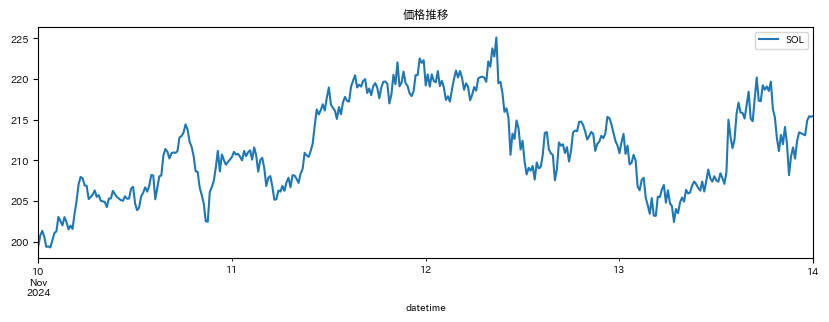

In [34]:
plt.figure(figsize=(10, 3))
plt.title('価格推移')
df['value'].plot(label='SOL')
plt.legend();

## 銘柄の一覧を取得

- 銘柄取得の際は、min_liquidityを指定する。

- Liquidityとは。
  - DEXでトークンを取引できる仕組み。
  - あるトークンとトークンをセットにして、流動性プールにロックする。取引したい人は、このプールの中に交換元トークンを預け入れて、交換先トークンを引き出す。
- つまりLiquidityが少ないということは、
  - ほとんど取引されない（価格変動があったとしても意味のない変動であったり、仕手の可能性）
  - 詐欺的なトークンの可能性。
  - その中から、Volumeがそこそこあるやつを絞ると実質100くらいしかない。

- Liquidityのミニマムを100万ドル（約1.5億円）に設定して取得する。
- Volumeの降順で取得する。

In [37]:
tokens = api.token_list('solana', sort='volume', asc=False, limit=50, min_liquidity=1_000_000)

In [38]:
tokens

,symbol,name,address,liquidity,mc,v24hChangePercent,v24hUSD
symbol,,,,,,,
SOL,SOL,Wrapped SOL,So11111111111111111111111111111111111111112,1.719038e+10,1.257203e+11,0.805871,4.415500e+09
USDC,USDC,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,1.038485e+10,3.184521e+09,-19.005222,1.594672e+09
USDT,USDT,USDT,Es9vMFrzaCERmJfrF4H2FYD4KCoNkY11McCe8BenwNYB,8.037669e+09,1.890664e+09,-16.413842,6.334472e+08
$WIF,$WIF,dogwifhat,EKpQGSJtjMFqKZ9KQanSqYXRcF8fBopzLHYxdM65zcjm,4.813070e+07,3.980200e+09,-29.787730,2.177204e+08
JLP,JLP,Jupiter Perps LP,27G8MtK7VtTcCHkpASjSDdkWWYfoqT6ggEuKidVJidD4,1.977261e+07,1.040264e+09,-24.296472,1.788612e+08
POPCAT,POPCAT,POPCAT,7GCihgDB8fe6KNjn2MYtkzZcRjQy3t9GHdC8uHYmW2hr,4.672473e+07,1.721801e+09,-16.381398,1.745961e+08
GOAT,GOAT,Goatseus Maximus,CzLSujWBLFsSjncfkh59rUFqvafWcY5tzedWJSuypump,2.792330e+07,8.938939e+08,8.594863,1.341029e+08
ACT,ACT,Act I : The AI Prophecy,GJAFwWjJ3vnTsrQVabjBVK2TYB1YtRCQXRDfDgUnpump,1.546437e+07,6.655356e+08,-29.894561,8.606799e+07
MOODENG,MOODENG,Moo Deng,ED5nyyWEzpPPiWimP8vYm7sD7TD3LAt3Q3gRTWHzPJBY,1.269322e+07,4.551300e+08,-27.800386,8.577685e+07


# データ取得とプロット

## GOALは「DEXで取引されているホットな銘柄を取得し、価格の騰落をプロットする」

### 最低出来高と最低Liquidityを指定して銘柄全件を取得

In [48]:
tokens = api.token_list_by_volume('solana', min_volume=5_000_000, min_liquidity=1_000_000)

In [49]:
tokens

,symbol,name,address,liquidity,mc,v24hChangePercent,v24hUSD
symbol,,,,,,,
SOL,SOL,Wrapped SOL,So11111111111111111111111111111111111111112,1.719038e+10,1.257203e+11,0.805871,4.415500e+09
USDC,USDC,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,1.038485e+10,3.184521e+09,-19.005222,1.594672e+09
USDT,USDT,USDT,Es9vMFrzaCERmJfrF4H2FYD4KCoNkY11McCe8BenwNYB,8.037669e+09,1.890664e+09,-16.413842,6.334472e+08
$WIF,$WIF,dogwifhat,EKpQGSJtjMFqKZ9KQanSqYXRcF8fBopzLHYxdM65zcjm,4.813070e+07,3.980200e+09,-29.787730,2.177204e+08
JLP,JLP,Jupiter Perps LP,27G8MtK7VtTcCHkpASjSDdkWWYfoqT6ggEuKidVJidD4,1.977261e+07,1.040264e+09,-24.296472,1.788612e+08
...,...,...,...,...,...,...,...
WORM,WORM,Deep Worm,DwDtUqBZJtbRpdjsFw3N7YKB5epocSru25BGcVhfcYtg,1.157938e+06,1.987839e+07,34.555844,5.431445e+06
EARL,EARL,earl,BjjvKX5k7gQoGRmvQAA5WMr7EkQ2cirGTSGxAznDpump,1.117177e+06,2.823963e+07,54.613186,5.330996e+06
OMEGA,OMEGA,OMEGA,3DkVGaNSMTcxFkgGDAm299FaVxgnCw2411vxZTmRpump,2.426119e+06,4.446099e+07,-2.883457,5.296297e+06


- 24時間Volume > 500万ドル の銘柄が92件取得できた。

### Liquidityの分布をプロット

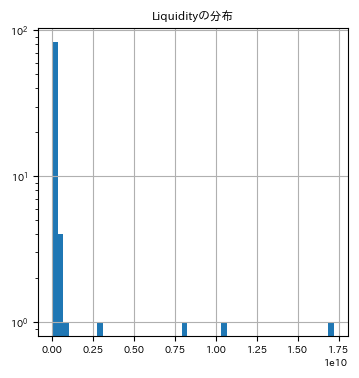

In [65]:
tokens['liquidity'].hist(bins=50)
plt.title('Liquidityの分布')
plt.yscale('log');

- ごく一部の銘柄のLiquidityが大きい。

### 24時間出来高をプロット

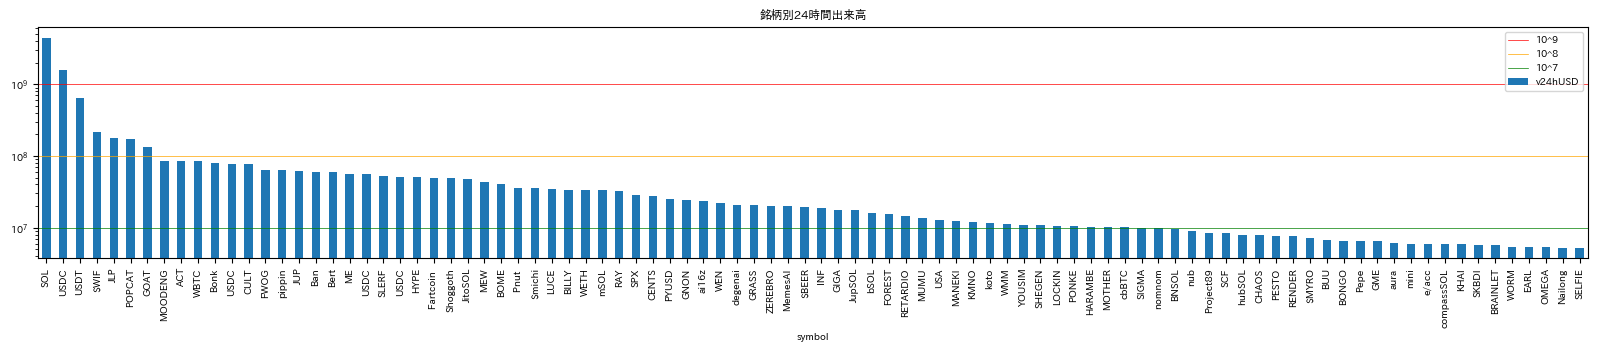

In [58]:
plt.figure(figsize=(20, 3))
tokens['v24hUSD'].plot(kind='bar')
plt.title('銘柄別24時間出来高')
plt.axhline(1e9, color='red', lw=0.5, label='10^9')
plt.axhline(1e8, color='orange', lw=0.5, label='10^8')
plt.axhline(1e7, color='green', lw=0.5, label='10^7')
plt.legend()
plt.yscale('log');

- PNUTとか意外に出来高がそこまで大きくない。
- SOLやステーブルコインの出来高が大きい。これは当然でクォート通貨だから。

### 24時間出来高変化をプロット

- ホットな銘柄の可能性がある。

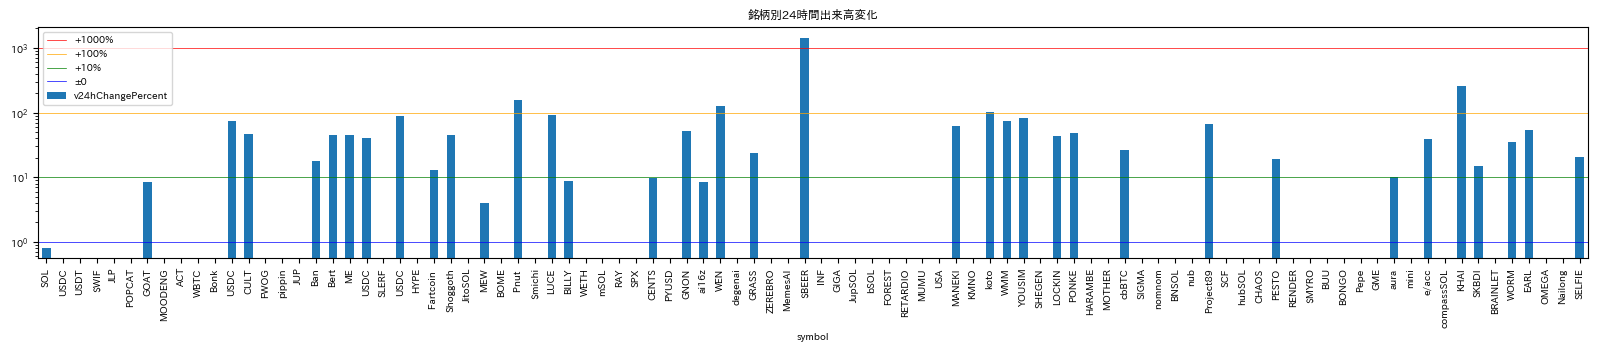

In [60]:
plt.figure(figsize=(20, 3))
tokens['v24hChangePercent'].plot(kind='bar')
plt.title('銘柄別24時間出来高変化')
plt.axhline(1000, color='red', lw=0.5, label='+1000%')
plt.axhline(100, color='orange', lw=0.5, label='+100%')
plt.axhline(10, color='green', lw=0.5, label='+10%')
plt.axhline(1, color='blue', lw=0.5, label='±0')
plt.legend()
plt.yscale('log');

- PNUTなどがやはり大きく増えている。
- 他にもよく分からないが取引量が増えている銘柄がいくつかある。

### 参考 Liquidityと24時間出来高の関係

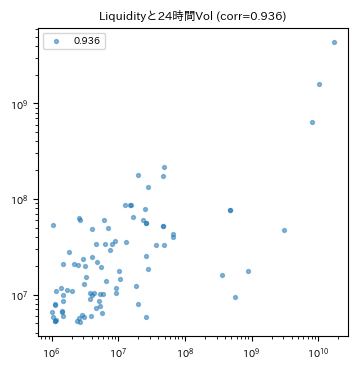

In [63]:
plot_corr(tokens['liquidity'], tokens['v24hUSD'], title='Liquidityと24時間Vol')
plt.xscale('log')
plt.yscale('log');

### 参考 Liquidityと24時間出来高変化の関係

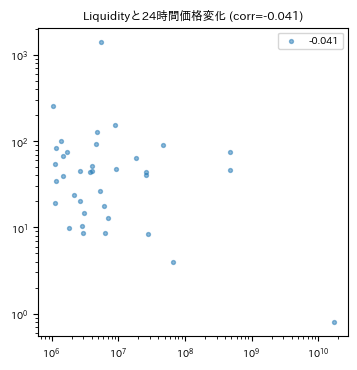

In [66]:
plot_corr(tokens['liquidity'], tokens['v24hChangePercent'], title='Liquidityと24時間価格変化')
plt.xscale('log')
plt.yscale('log');

### 大きく出来高が増えている銘柄を取得

- ここ24時間で出来高が50%以上増えているものを取得.

In [71]:
hot_tokens = tokens[tokens['v24hChangePercent'] > 50]
hot_tokens

,symbol,name,address,liquidity,mc,v24hChangePercent,v24hUSD
symbol,,,,,,,
USDC,USDC,USDC,5eAFeLUBnFLKNwuAuqdYGw77JudfeybftVN397eWuqeJ,4.797676e+08,8.998040e+09,74.837596,7.705260e+07
USDC,USDC,USDC,E5JfcSWUa9175yNUnRR37tJZ7obCykCNGYErRvnPkrki,4.667480e+07,8.996394e+09,89.768922,5.166015e+07
Pnut,Pnut,Peanut the Squirrel,2qEHjDLDLbuBgRYvsxhc5D6uDWAivNFZGan56P1tpump,8.802561e+06,1.256124e+08,155.367830,3.604110e+07
LUCE,LUCE,Official Mascot of the Holy Year,CBdCxKo9QavR9hfShgpEBG3zekorAeD7W1jfq2o3pump,4.561445e+06,6.013152e+07,91.611844,3.418151e+07
GNON,GNON,numogram,HeJUFDxfJSzYFUuHLxkMqCgytU31G6mjP4wKviwqpump,4.037228e+06,2.913434e+07,51.228482,2.444574e+07
WEN,WEN,Wen,WENWENvqqNya429ubCdR81ZmD69brwQaaBYY6p3LCpk,4.812963e+06,1.250120e+08,126.414077,2.181925e+07
$BEER,$BEER,BEER,AujTJJ7aMS8LDo3bFzoyXDwT3jBALUbu4VZhzZdTZLmG,5.485551e+06,2.182903e+07,1427.195790,1.932501e+07
MANEKI,MANEKI,MANEKI,25hAyBQfoDhfWx9ay6rarbgvWGwDdNqcHsXS3jQ3mTDJ,1.841306e+07,7.454029e+07,63.047967,1.238129e+07
koto,koto,koto,BfdVHnbt9LSNAFCZU9kvTjbrH3jX78sv2siLKGQ7pump,1.377638e+06,1.555958e+07,101.625931,1.164169e+07


In [70]:
hot_symbols = tokens[tokens['v24hChangePercent'] > 50]['symbol'].values
hot_symbols

array(['USDC', 'USDC', 'Pnut ', 'LUCE', 'GNON', 'WEN', '$BEER', 'MANEKI',
       'koto', 'WMM', 'YOUSIM', 'Project89', 'KHAI', 'EARL'], dtype=object)

In [73]:
len(hot_symbols)

14

### 価格を取得してプロット

In [80]:
prices = {}
from_time = int(datetime(2024, 11, 13, 12, 0).timestamp())
to_time = int(datetime(2024, 11, 14, 12, 0).timestamp())
for symbol, address in hot_tokens['address'].items():
    prices[symbol] = api.history_price('solana', address, from_time, to_time, interval='15m')


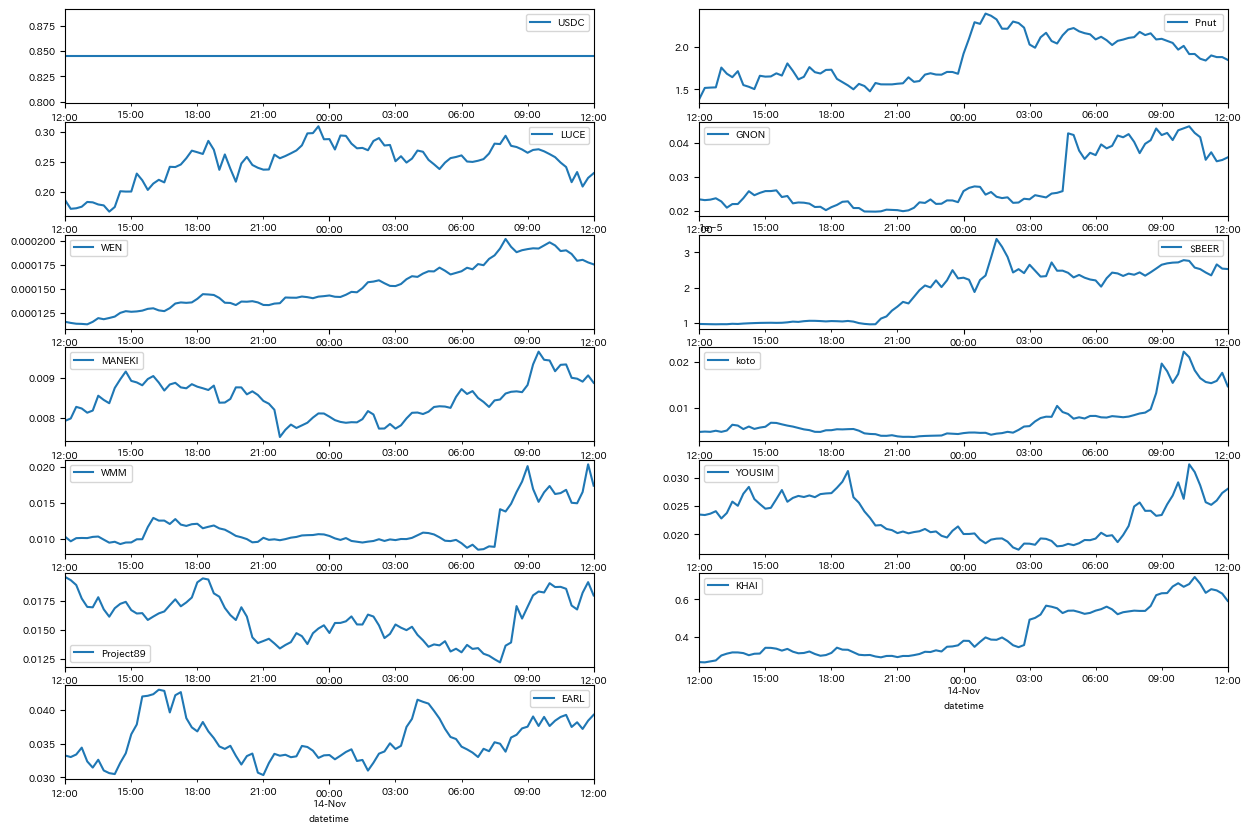

In [81]:
plt.figure(figsize=(15, 10))
for i, (symbol, price) in enumerate(prices.items()):
    plt.subplot(7, 2, i+1)
    prices[symbol]['value'].plot(label=symbol)
    plt.legend()
plt.show();

- 分かりづらいので、開始時点を1として併せてプロットする。

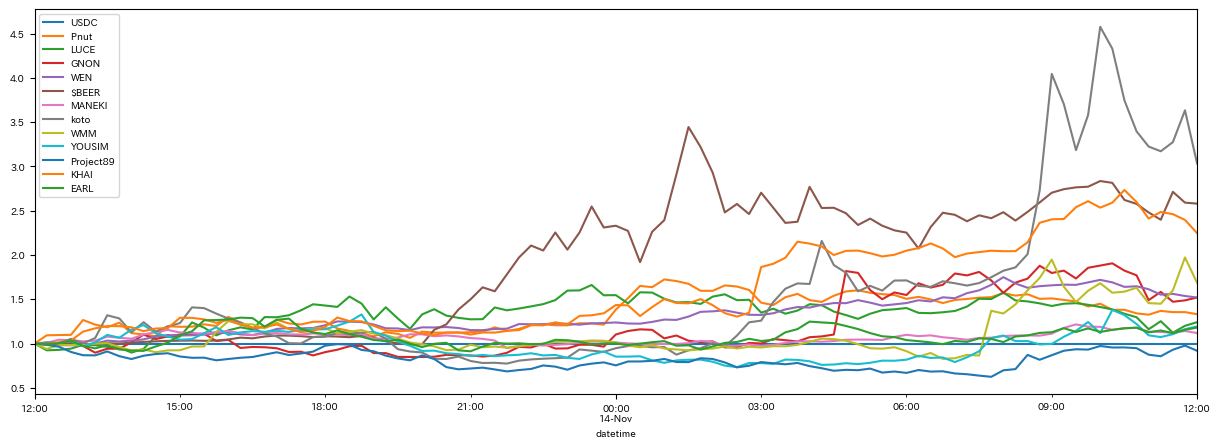

In [83]:
plt.figure(figsize=(15, 5))
for i, (symbol, price) in enumerate(prices.items()):
    (prices[symbol]['value'] / prices[symbol]['value'].iloc[0]).plot(label=symbol)
plt.legend();

- ﾍﾟﾛﾘ　これは･･･バブル！！

## 一応有料APIでできることを紹介

- ※案件ではありません。
- ※僕はBirdEyeのサポートではないので、詳細な使い方や質問はサポートにお願いします。

- 各銘柄の概要（ウォレット数、ホルダー数、トランザクション数、トップ層のホルダーの残高やパーセンテージなど）
- 各銘柄のOHLCV
- トレンド銘柄、新規リスティング銘柄
- 各ペア（例えばSOL-PNUT）の価格や出来高、OHLCV
- 各銘柄のトップトレーダーの情報
- 各トレーダーのトレード内容や資産内訳
- など。詳しくはDocで確認してください。

# まとめと再度の注意

- DEXではできることが広がる。
- <font color="red">ただし、詐欺的なものに本当に注意。取引の前には事前に入念に下調べをして、自己責任でお願いします。</font>
- <font color="red">上記で抽出したトークンの中には、詐欺的なもの、仕手的なものが含まれている可能性があり、必ず人力で精査する必要があります。</font>
- DEXを戦場にするためには、こうしたAPIサービスのみでは不十分。沼なので入り込むときは注意しましょう。

# 質問コーナー

- bybitで、BTCを担保にミーム等に投資する2階建てに挑戦したいけど、適切なリスク（ポジション量）や方法が分かりません。

- 2階建てとは？
  - 1階部分（証拠金）にBTCなどのドル建て変動資産を使用する。
  - 証拠金を、BTCなどを担保に借りたFIATでまかなう。
  - ロングシフト ... USD系を証拠金にしつつ、レバ1倍分のBTCロングポジションを余分に積む など

- 注意事項としては、
  - 最も避けなければならないのは2階部分のロスカットと、証拠金に使っているBTCが担保割れして清算されてしまうこと。
  - まずはbybitのUTAの仕様をしっかり確認しましょう
  - BTCの証拠金率は95%。証拠金維持率100%で新規建て不可、80%で強制的に資産売却。
  - https://learn.bybit.com/ja/bybit-guide/how-to-use-the-bybit-unified-trading-account-for-effective-risk-management/
  - https://announcements.bybit.com/ja-JP/article/adjustments-to-maintenance-margin-calculations-blt7811a5327c6a2471/
  - 

- 適切なリスクの目安
  - BTCの現在価値にだいたい60～70%を掛けた金額を実際の証拠金として利用する。
  - あとは通常と同じ。下げのときは資産の評価額がドル建てでぐっと落ちるが、1階部分の下げは気にしなくてよいので、2階部分のPNLに集中する。
  - ショートはしない（損失が無限大になる可能性）。
    - 通常銘柄のショートならレバ0.5倍くらいまでなら大丈夫と考える（ショートで焼かれるときは証拠金BTCも上がっている可能性が高い）が、ミームは別。
  - ロングの場合、通常と同じくボラティリティに応じてレバレッジを決める。
    - ボラティリティと最大許容ドローダウンから決める。
    - 例えば直近のボラティリティから、20%下落の可能性あり、かつ最大許容ドローダウンが20%であれば、当然レバは1倍。